# Pokemon Generator

### Part 1: CNN for the categorisation of Pokemon stats
This part of the program is designed to accept the image of a Pokemon character and predict the main 4 characteristics of the Pokemon: Height, Weight, Type1, Type2, Weakness. The CNN will be used to categorise the newly generated Pokemon output from the GAN in Part 2.


### Part 2: GAN for the creation of a brand new Pokemon 
The goal of the GAN is to train two seperate networks, a Generator and a Discriminator. One network aims to manipulate an image of pure noise to a realistic image of a Pokemon, while the other attempts to distinguish between 'real' and 'fake' images from the original dataset and the Generator network. The two networks will continue to learn as they battle, with the Generator producing more and more realistic images for the Discriminator to classify. 

### Part 3: Using the CNN to categorise a new 'Pokemon'
The outputs from our experiment will be displayed, showing both the new 'Pokemon' that has been created as well as it's Height, Weight, Type1, Type2 and Weakness stats. 

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd

from PIL import Image
import os 
import csv

## Importing the Pokemon images

There are 809 official Pokemon designed for the original Pokemon games and the images from this project are available online for free. Over the lifetime of the Pokemon franchise, there have been many generations and artwork renditions. The two most clear and complete datasets were provided by https://www.pokemon.com/us/pokedex/ and these have been used for this project. 
 
### Datasets
- small:  contains 120x120 pixel title pictures for each Pokemon from original designs
- alt:    contains 215x215 pixel pictures for each Pokemon from digitally remastered designs
- big:    contains 475x475 pixel, high-res versions of 386 Pokemon from the alt dataset
- extra:  contains varying sized images with additional view angles of Pokemon in varying styles

In [27]:
images = []

file_paths = ["Dataset/small/", "Dataset/alt/", "Dataset/extra/", "Dataset/big/"]
rgb_white = 255
temp_training_data = []
name_label_data = []
img_size = 60

def importPokeImages(path):
    for img in os.listdir(path):
    
        if(img[-4:].lower() == ".png" or img[-4:].lower() == ".jpg"):
            image = np.array(Image.open(path + img).convert("RGBA").resize((img_size, img_size)))
            r, g, b, a = np.rollaxis(image, axis=-1)
            # Handelling image whitespace
            r[a == 0] = rgb_white
            g[a == 0] = rgb_white
            b[a == 0] = rgb_white 
            image = np.dstack([r, g, b])

            # Append image to set
            temp_training_data.append(image)

            # Append | flipped image to set
            temp_training_data.append(np.fliplr(image))

            # Append -- flipped image to set
            temp_training_data.append(np.flipud(image))

            # Append double flipped image to set
            temp_training_data.append(np.fliplr(np.flipud(image)))
            
            
            # Append label data
            if(" " in img[:-4]):
                for x in range(4):
                    name_label_data.append(img[:-4][:img[:-4].find(" ")].capitalize())
                    
            elif("-" in img[:-4]):
                for x in range(4):
                    name_label_data.append(img[:-4][:img[:-4].find("-")].capitalize())
            else:
                for x in range(4):
                    name_label_data.append(img[:-4].capitalize())
             


            
# Importing each dataset - comment out if neccessary 
importPokeImages(file_paths[0])
importPokeImages(file_paths[1])
importPokeImages(file_paths[2])
importPokeImages(file_paths[3])

training_data = np.array(temp_training_data).reshape(-1, img_size, img_size, 3) 

## Dataset augmentation
During the import process, each of the images imported have been transformed into three new versions for the network to learn from. This allows us to use 4x as much training data for our network to learn from for our prediction. As we are only concerned about classification at this stage, the orientation of the Pokemon is not important. 

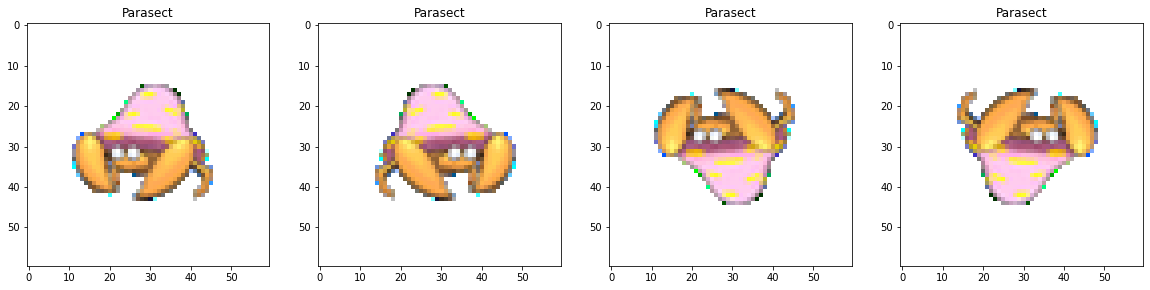

In [33]:
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1,4,1)
plt.title(name_label_data[0])
plt.imshow(training_data[0])

# Flipped | image
plt.subplot(1,4,2)
plt.title(name_label_data[1])
plt.imshow(training_data[1])

# Flipped -- image
plt.subplot(1,4,3)
plt.title(name_label_data[2])
plt.imshow(training_data[2])

# Double flipped image
plt.subplot(1,4,4)
plt.title(name_label_data[3])
plt.imshow(training_data[3])

plt.show()

## Importing the Pokemon stats

There are 809 official Pokemon which have been allocated many stats, however we will only focus on two of these attributes:
 - Type 1
 - Type 2
 
These stats will be used as the outputs for the CNN, although more are available for future development.

In [29]:
import pandas as pd

pokemon = pd.read_csv('Dataset/pokemon.csv')

pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# Extracting Pokemon stat data
There are 18 seperate 'Types' that a Pokemon can be and each Pokemon has either one or two types.
Each of the types are defined below in both String and One-Hot form. The One-Hot encoding of this data makes it much easier for a neural network to categorise and find trends in data. Simply, string data is too inconsistent for trend analysis. 

In [30]:
types = ["Bug","Dark","Dragon","Electric","Fairy","Fighting",
        "Fire","Flying","Ghost","Grass","Ground","Ice",
        "Normal","Poison","Psychic","Rock","Steel","Water"]


# Method to decode the One Hot encoding of types into a readable string
def oh_decoder(my_type):
    type1= "NULL" 
    type2 = "NULL"
    
    for x in range(len(my_type)):
        if(my_type[x] == 1 and type1 == "NULL"):
            type1 = types[x]
        elif(my_type[x] == 1):
            type2 = types[x]
            
    
    return str(type1) + " / " + str(type2);

# One-Hot Encoding
Each of the pokemon images imported to the program are associated to one name label. These name labaled will be used to search through a Pokemon csv file with all associated stats. Once found, the One-Hot encoded types will be stored in a seperate list. When a Pokemon has two types, the one-hot encoded types will be combined in order to prevent multiple entries for each Pokemon. 

In [53]:
oh_lables = np.zeros((len(name_label_data),len(types)))


# Loop through each imported pokemon image
for x in range(len(name_label_data)):
 
    # Find the related Pokemon from the CSV file (there are multiple with the same single Poke ID)
    for y in range(len(pokemon)):
        if(name_label_data[x].lower() == str(pokemon['Name'][y].lower())):
            for z in range(len(types)):
                    if(types[z] == pokemon['Type 1'][y]):
                        oh_lables[x][z] = 1
            
            # As most Pokemon only have one 'Type' attribute but some have two, using both attributes with the 
            # 'One-Hot-Encoding' technique means that it is almost impossible for the CNN to learn from the data.
            # These inconsistencies mean that either one or two types should be predicted, resulting in an 
            # exponentially growing loss. Therefore, only the first (Primary) 'Type' atribute will be used in this stage.
            
            '''
            # For Pokemon with only ONE Type
            if(str(pokemon['Type 2'][y]) == "NaN"):
                for z in range(len(types)):
                    if(types[z] == pokemon['Type 1'][y]):
                        oh_lables[x][z] = 1
                       
            # For Pokemon with TWO types        
            else:
                for z in range(len(types)):
                    if(types[z] == pokemon['Type 1'][y]):
                        oh_lables[x][z] = 1
                        
                    if(types[z] == pokemon['Type 2'][y]):
                        oh_lables[x][z] = 1
            '''
            

# Fully Labelled and Encoded Dataset
We have now achieved an image dataset with both name and type labels, ready for entry to the CNN. Although the type labels have been One-Hot encoded, it is possible to deduce the name and type of any Pokemon into a readable string format. 

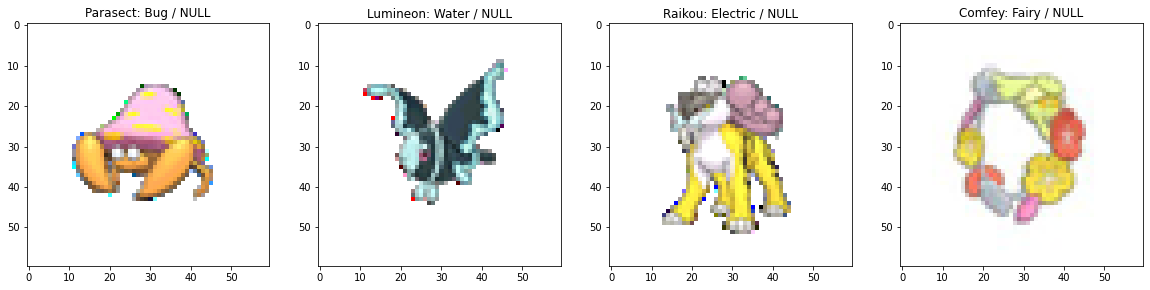

In [54]:
plt.figure(figsize=(20, 5))

# Original image
plt.subplot(1,4,1)
plt.title(str(name_label_data[0]) + ": " + str(oh_decoder(oh_lables[0])))
plt.imshow(training_data[0])

# Flipped | image
plt.subplot(1,4,2)
plt.title(str(name_label_data[4]) + ": " + str(oh_decoder(oh_lables[4])))
plt.imshow(training_data[4])

# Flipped -- image
plt.subplot(1,4,3)
plt.title(str(name_label_data[8]) + ": " + str(oh_decoder(oh_lables[8])))
plt.imshow(training_data[8])

# Double flipped image
plt.subplot(1,4,4)
plt.title(str(name_label_data[12]) + ": " + str(oh_decoder(oh_lables[12])))
plt.imshow(training_data[12])

plt.show()

# Splitting Training and Testing Data

The dataset must be split between training and testing data. If the same data is used for training and testing, the model will become overfitted to the training data and accuracy results will appear to be much higher than any real-world example would produce. 

In [55]:
split = 0.9

# Defining training/testing split 
datasplit = int(len(training_data)*split)

# Defining the training and testing datasets /// Normalisation of pixel data between 0-1
x_train = training_data[:datasplit].astype('float32') / 255.
x_test = training_data[datasplit:].astype('float32') / 255.

y_train = oh_lables[:datasplit]
y_test = oh_lables[datasplit:]

print("Unsplit data:  " + str(training_data.shape) + "\n")
print("Training data: " + str(x_train.shape))
print("Testing labels: " + str(y_test.shape) + "\n")
print("Testing data:  " + str(x_test.shape))
print("Training labels: " + str(y_train.shape))


Unsplit data:  (14360, 60, 60, 3)

Training data: (12924, 60, 60, 3)
Testing labels: (1436, 18)

Testing data:  (1436, 60, 60, 3)
Training labels: (12924, 18)


## Building the CNN
Now that we have created our training and testing lables and data, we can run our machine learning models to compute useful results. In the next section, we will be using a Convolutional Neural Network (CNN) to make predictions about the 'Type' attribute of Pokemon based on their images. 

In order to find an optimal solution, three seperate models have been created at varying complexities. The accuracy of each model is recorded and plot below in order to easily compare the success of each implementation. 

In [56]:
channels = 3
img_shape = (img_size, img_size, channels)
num_classes = 18
print(y_train.shape)
print(x_train.shape)

(12924, 18)
(12924, 60, 60, 3)


In [57]:
for x in range(10):
    if(x%4==0):
        print(y_train[x])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [58]:
def create_model():
    model = keras.Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(num_classes, activation="softmax"))
    
    return model

In [59]:
def create_model2():
    model = keras.Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=img_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [60]:
def create_model3():
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [61]:
model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

Epoch 1/50
202/202 [==============================] - 87s 431ms/step - loss: 2.8528 - accuracy: 0.1795 - val_loss: 2.3296 - val_accuracy: 0.3155
Epoch 2/50
202/202 [==============================] - 87s 430ms/step - loss: 2.2075 - accuracy: 0.3209 - val_loss: 2.2442 - val_accuracy: 0.3231
Epoch 3/50
202/202 [==============================] - 87s 432ms/step - loss: 1.5218 - accuracy: 0.5358 - val_loss: 2.2568 - val_accuracy: 0.3182
Epoch 4/50
202/202 [==============================] - 89s 440ms/step - loss: 0.7853 - accuracy: 0.7677 - val_loss: 2.4582 - val_accuracy: 0.2939
Epoch 5/50
202/202 [==============================] - 90s 444ms/step - loss: 0.3669 - accuracy: 0.9030 - val_loss: 2.8529 - val_accuracy: 0.3078
Epoch 6/50
202/202 [==============================] - 90s 447ms/step - loss: 0.1583 - accuracy: 0.9617 - val_loss: 3.1513 - val_accuracy: 0.2987
Epoch 7/50
202/202 [==============================] - 88s 437ms/step - loss: 0.0850 - accuracy: 0.9863 - val_loss: 3.6062 - val_ac

KeyboardInterrupt: 

In [ ]:
model = create_model2()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

In [ ]:
model = create_model3()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=64)

# Results
The below graphs will directly compare the accuracy of each of the three models created above.

In [ ]:
# plot testing accuracy
plt.figure(2, figsize=(10,10))
ax1 = plt.subplot(1, 1, 1)

ax1.plot(history.history['acc'], label='Accuracy - Model 1')
ax1.plot(history2.history['acc'], label='Accuracy - Model 2')
ax1.plot(history3.history['acc'], label='Accuracy - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


# plot validation accuracy
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['val_acc'], label='Accuracy - Model 1')
ax2.plot(history2.history['val_acc'], label='Accuracy - Model 2')
ax2.plot(history3.history['val_acc'], label='Accuracy - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Accuracy', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()

# plot testing loss
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['loss'], label='Loss - Model1')
ax2.plot(history2.history['loss'], label='Loss - Model 2')
ax2.plot(history3.history['loss'], label='Loss - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Training Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


# plot testing loss
plt.figure(2, figsize=(10,10))
ax2 = plt.subplot(1, 1, 1)
ax2.plot(history.history['val_loss'], label='Loss - Model 1')
ax2.plot(history2.history['val_loss'], label='Loss - Model 2')
ax2.plot(history3.history['val_loss'], label='Loss - Model 3')

plt.xlabel('Epochs', size=15)
plt.ylabel('%', size=15)
plt.title('Validation Loss', size=20)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.legend()
plt.show()


## Building the GAN
This part of the project will aim to create the image of a completely new Pokemon character. A Generative Aversarial Network (GAN) will be used to transform an image of pure noise into one of a recognisable Pokemon character. This can be achieved by running two Neural Networks in parallel, one designed to create the above mentionend Pokemon image and the other to distinguish between a 'real' Pokemon and a 'fake', or generated Pokemon. These are named a Generator Network and Discriminator Network respectively. 

As the success of the Generator improves, the Discriminator will have an increasingly difficult job trying to decipher which images are 'real' and which are 'fake'. This friendly competition will result in an output from the Generator which looks closer and closer to a Pokemon character. 

In [ ]:
#Specify parameters of the training dataset
latent_dim = 100
x_train_gan = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_gan = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [ ]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    '''
    generator.add(Dense(units=1024*2))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024*4))
    generator.add(LeakyReLU(0.2))
    '''
    generator.add(Dense(units=np.prod(img_shape), activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator


g = create_generator()
g.summary()

In [ ]:
def create_discriminator():
    discriminator=Sequential()
    '''
    discriminator.add(Dense(units=1024*4,input_dim=np.prod(img_shape)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    
    discriminator.add(Dense(units=1024*2))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    '''
    discriminator.add(Dense(units=1024,input_dim=np.prod(img_shape)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator
d = create_discriminator()
d.summary()

In [ ]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

In [ ]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,img_size,img_size,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    batch_count = x_train_gan.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =x_train_gan[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
           
            plot_generated_images(e, generator)
            
training(2880,128)

## Future Improvements
- More images
- Flip Images
- Find model with premade weights